In [66]:
!pip install xlrd

In [67]:
!pip install scikit-fuzzy pyswarm

In [68]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from skfuzzy import control as ctrl
from skfuzzy import cluster
from pyswarm import pso
import calendar

In [69]:
df= pd.read_excel("migass.xlsx")
df

,No,Tahun,Bulan,Nilai Impor migas (Juta US$)
0,1,1993,Januari,132.2
1,2,1993,Februari,154.4
2,3,1993,Maret,112.1
3,4,1993,April,142.8
4,5,1993,Mei,153.8
...,...,...,...,...
371,372,2023,Desember,3372.4
372,373,2024,Januari,2698.3
373,374,2024,Februari,2979.6
374,375,2024,Maret,3326.5


In [70]:
print(df.head())

   No   Tahun     Bulan  Nilai Impor migas (Juta US$)
0    1   1993   Januari                         132.2
1    2   1993  Februari                         154.4
2    3   1993     Maret                         112.1
3    4   1993    April                          142.8
4    5   1993       Mei                         153.8


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   No                            376 non-null    int64  
 1   Tahun                         376 non-null    int64  
 2   Bulan                         376 non-null    object 
 3   Nilai Impor migas (Juta US$)  376 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.9+ KB


In [72]:
if 'No' in df.columns:
    df.drop(columns=['No'], inplace=True)

In [73]:
df.isna().sum()

No                              0
Tahun                           0
Bulan                           0
Nilai Impor migas (Juta US$)    0
dtype: int64

In [74]:
bulan_indonesia = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']

In [75]:
df['Bulan'] = df['Bulan'].str.strip()

In [76]:
df['Tanggal'] = df.apply(lambda row: datetime(row['Tahun'],
                                              bulan_indonesia.index(row['Bulan']) + 1,
                                              1), axis=1)
df.set_index('Tanggal', inplace=True)

In [77]:
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]['Nilai Impor migas (Juta US$)']
test_data = df.iloc[train_size:]['Nilai Impor migas (Juta US$)']

In [78]:
def fuzzy_time_series(data, order):
    fuzzy_series = []
    data_length = len(data)
    for i in range(data_length - order):
        pattern = tuple(data[i:i+order])
        next_value = data[i+order]
        fuzzy_series.append((pattern, next_value))
    return fuzzy_series

In [79]:
order = 3
fuzzy_series = fuzzy_time_series(train_data.values, order)

In [80]:
def build_transition_matrix(fuzzy_series, order):
    patterns = {}
    for pattern, next_value in fuzzy_series:
        if pattern not in patterns:
            patterns[pattern] = []
        patterns[pattern].append(next_value)

    transition_matrix = {}
    for pattern, next_values in patterns.items():
        next_values_counts = {v: next_values.count(v) for v in set(next_values)}
        total_counts = sum(next_values_counts.values())
        transition_matrix[pattern] = {v: count/total_counts for v, count in next_values_counts.items()}

    return transition_matrix

In [81]:
transition_matrix = build_transition_matrix(fuzzy_series, order)

In [82]:
def build_transition_matrix(fuzzy_series, order):
    patterns = {}
    for pattern, next_value in fuzzy_series:
        if pattern not in patterns:
            patterns[pattern] = []
        patterns[pattern].append(next_value)

    transition_matrix = {}
    for pattern, next_values in patterns.items():
        next_values_counts = {v: next_values.count(v) for v in set(next_values)}
        total_counts = sum(next_values_counts.values())
        transition_matrix[pattern] = {v: count/total_counts for v, count in next_values_counts.items()}

    return transition_matrix

In [83]:
transition_matrix = build_transition_matrix(fuzzy_series, order)

In [84]:
def forecast(data, transition_matrix, order, steps):
    forecasts = []
    current_pattern = tuple(data[-order:])
    for _ in range(steps):
        if current_pattern in transition_matrix:
            next_value = max(transition_matrix[current_pattern], key=transition_matrix[current_pattern].get)
        else:
            next_value = np.mean(data)  # Default to mean if pattern not found
        forecasts.append(next_value)
        current_pattern = tuple(list(current_pattern[1:]) + [next_value])
    return forecasts


In [85]:
steps = len(test_data)  # Peramalan untuk panjang data uji
forecasts = forecast(train_data.values, transition_matrix, order, steps)

In [86]:
def create_flr_table(fuzzy_series):
    flr_table = []
    for (pattern, next_value) in fuzzy_series:
        flr_table.append({
            'Periode': len(flr_table) + 1,
            'Nilai Impor (US dollar)': pattern,
            'FLR': next_value
        })
    return pd.DataFrame(flr_table)

flr_table = create_flr_table(fuzzy_series)

In [87]:
def create_linguistic_table(data, forecasts):
    linguistic_table = []
    for i in range(len(data)):
        linguistic_table.append({
            'Periode': i + 1,
            'Nilai Impor (US dollar)': data[i],
            'Fuzzifikasi': 'A' if i < len(forecasts) else 'B',  # Contoh sederhana
            'Hasil': forecasts[i] if i < len(forecasts) else np.nan
        })
    return pd.DataFrame(linguistic_table)

In [88]:
linguistic_table = create_linguistic_table(train_data.values, forecasts)

In [89]:
def create_error_table(test_data, forecasts):
    error_table = []
    for i in range(len(test_data)):
        actual = test_data[i]
        forecast = forecasts[i]
        ape = abs((actual - forecast) / actual) * 100
        error_table.append({
            'Periode': len(train_data) + i + 1,
            'Nilai Impor (US dollar)': actual,
            'Fuzzifikasi': forecast,
            'APE': ape
        })
    mape = np.mean([row['APE'] for row in error_table])
    error_table.append({
        'Periode': 'MAPE',
        'Nilai Impor (US dollar)': '',
        'Fuzzifikasi': '',
        'APE': mape
    })
    return pd.DataFrame(error_table)

In [90]:
error_table = create_error_table(test_data.values, forecasts)

In [91]:
def create_pso_results_table(iterations, particles, w, c1, c2, mape):
    pso_results = []
    for i in range(iterations):
        pso_results.append({
            'No.': i + 1,
            'Iterasi': i + 1,
            'Jumlah Partikel': particles,
            'W (Bobot inersia)': w,
            'Nilai C1': c1,
            'Nilai C2': c2,
            'MAPE': mape
        })
    return pd.DataFrame(pso_results)

In [92]:
iterations = 10  # Contoh jumlah iterasi
particles = 30  # Contoh jumlah partikel
w = 0.5  # Contoh nilai bobot inersia
c1 = 1.5  # Contoh nilai C1
c2 = 1.5  # Contoh nilai C2
mape = error_table['APE'].iloc[:-1].mean()  # Menggunakan MAPE dari tabel error sebelumnya

pso_results_table = create_pso_results_table(iterations, particles, w, c1, c2, mape)


In [93]:
print("Tabel III-2: Tabel Fuzzy Logic Relationship (FLR)")
print(flr_table)
print("\nTabel III-3: Pemetaan Nilai Linguistik")
print(linguistic_table)
print("\nTabel III-4: Error Calculation")
print(error_table)
print("\nTabel III-5: Hasil Pengujian FTS Markov Chain dengan PSO")
print(pso_results_table)

Tabel III-2: Tabel Fuzzy Logic Relationship (FLR)
     Periode   Nilai Impor (US dollar)     FLR
0          1     (132.2, 154.4, 112.1)   142.8
1          2     (154.4, 112.1, 142.8)   153.8
2          3     (112.1, 142.8, 153.8)   232.5
3          4     (142.8, 153.8, 232.5)   108.2
4          5     (153.8, 232.5, 108.2)   252.1
..       ...                       ...     ...
292      293  (1791.6, 1600.6, 1778.7)  2011.2
293      294  (1600.6, 1778.7, 2011.2)  1934.6
294      295  (1778.7, 2011.2, 1934.6)  2206.9
295      296  (2011.2, 1934.6, 2206.9)  2204.4
296      297  (1934.6, 2206.9, 2204.4)  2563.2

[297 rows x 3 columns]

Tabel III-3: Pemetaan Nilai Linguistik
     Periode  Nilai Impor (US dollar) Fuzzifikasi        Hasil
0          1                    132.2           A  1445.392667
1          2                    154.4           A  1445.392667
2          3                    112.1           A  1445.392667
3          4                    142.8           A  1445.392667
4      

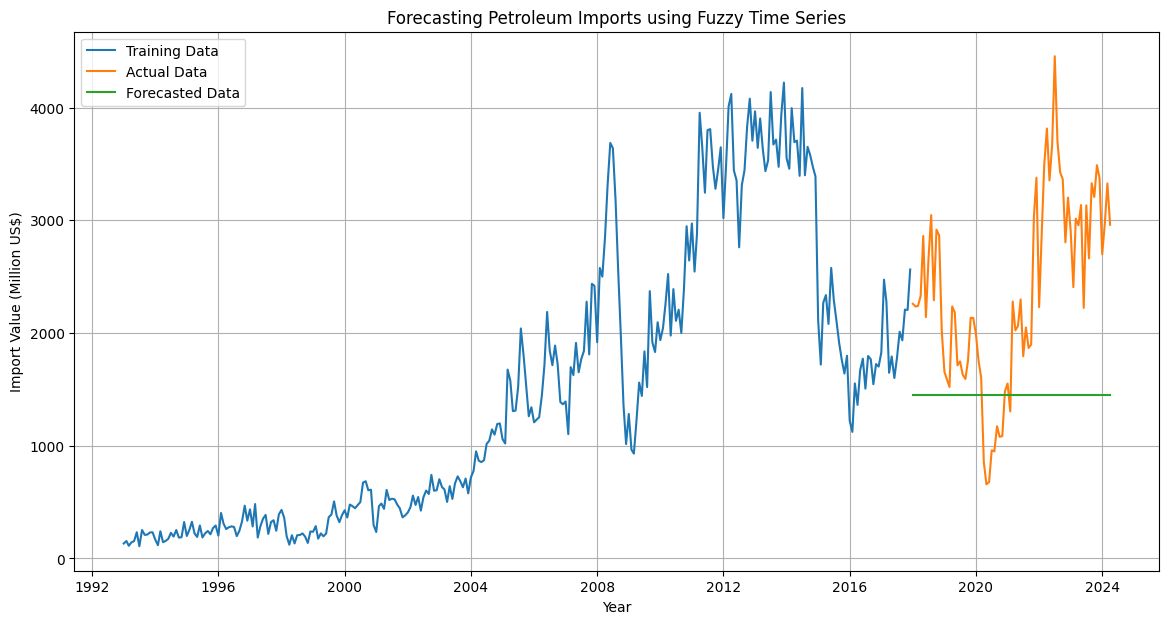

In [94]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data.values, label='Training Data')
plt.plot(test_data.index, test_data.values, label='Actual Data')
plt.plot(test_data.index, forecasts, label='Forecasted Data')
plt.title('Forecasting Petroleum Imports using Fuzzy Time Series')
plt.xlabel('Year')
plt.ylabel('Import Value (Million US$)')
plt.legend()
plt.grid(True)
plt.show()